<a href="https://colab.research.google.com/github/kayvour/Tamil-and-Malayalam-Political-Meme-Classification/blob/main/speech_vilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.38.2 pytesseract pillow scikit-learn tqdm openpyxl
!apt-get install tesseract-ocr -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
import os
import torch
import pandas as pd
import pytesseract
import numpy as np
import re
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from transformers import ViltProcessor, ViltModel

BASE_PATH = "/content/drive/MyDrive/meme"
IMG_PATH = os.path.join(BASE_PATH, "Train_images")
LABEL_PATH = os.path.join(BASE_PATH, "Train_labels.xlsx")


In [ ]:
df = pd.read_excel(LABEL_PATH)

le = LabelEncoder()
df['label'] = le.fit_transform(df['Level2'])

num_classes = len(le.classes_)
print("Classes:", le.classes_)


Classes: ['Support for party' 'Support for person' 'Troll/Oppose Against Party'
 'Troll/Oppose Against Person']


In [ ]:
def clean_ocr_text(text, max_words=40):
    text = text.replace("\n", " ")
    text = re.sub(r"[^a-zA-Z0-9.,!? ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.split()[:max_words]
    return " ".join(words)

def extract_text(image_path):
    try:
        img = Image.open(image_path)
        raw = pytesseract.image_to_string(img)
        return clean_ocr_text(raw)
    except:
        return ""


In [ ]:
df["image_path"] = df["Image_name"].apply(lambda x: os.path.join(IMG_PATH, x))

tqdm.pandas()
df["text"] = df["image_path"].progress_apply(extract_text)

df.head()


100%|██████████| 803/803 [17:28<00:00,  1.31s/it]


,Image_id,Image_name,Level1,Level2,label,image_path,text
0,0,000.jpg,Troll/Oppose,Troll/Oppose Against Person,3,/content/drive/MyDrive/meme/Train_images/000.jpg,"Qovil GoncvssHy,,,!!!22727Q ooh WHJSHEOL,,, TE..."
1,2,002.jpg,Troll/Oppose,Troll/Oppose Against Person,3,/content/drive/MyDrive/meme/Train_images/002.jpg,Suipled crips Sa mislvusHlev D EMMEOTITED SH F...
2,3,003.jpg,Troll/Oppose,Troll/Oppose Against Person,3,/content/drive/MyDrive/meme/Train_images/003.jpg,ax Tey OC tito MMR oot toy re YW a Pet Melt oo...
3,4,004.jpg,Troll/Oppose,Troll/Oppose Against Party,2,/content/drive/MyDrive/meme/Train_images/004.jpg,BREAKING NEWS Boe es ae Ws Raed Bhd kl Oca gQl...
4,5,005.jpg,Troll/Oppose,Troll/Oppose Against Person,3,/content/drive/MyDrive/meme/Train_images/005.jpg,FOMWUMPHISOMUNGIL QL QHSSLHSG FLL Q wimhmM Cou...


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from torchvision import transforms

resize_transform = transforms.Resize((384, 384))  # ViLT default size

class MemeDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row["image_path"]).convert("RGB")
        image = resize_transform(image)  # 🔥 FORCE FIXED SIZE

        text = row["text"]
        label = row["label"]

        encoding = self.processor(
            images=image,
            text=text,
            padding="max_length",
            truncation=True,
            max_length=40,
            return_tensors="pt"
        )

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = torch.tensor(label)

        return encoding


In [ ]:
train_dataset = MemeDataset(train_df, processor)
test_dataset  = MemeDataset(test_df, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8)


In [ ]:
class ViltClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vilt = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vilt.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, pixel_values, labels=None, **kwargs):
        outputs = self.vilt(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )

        pooled = outputs.pooler_output
        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return {"loss": loss, "logits": logits}


In [ ]:
model = ViltClassifier(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss/len(train_loader))


100%|██████████| 81/81 [23:42<00:00, 17.56s/it]


Epoch 1 Loss: 0.9384432008237015


100%|██████████| 81/81 [23:00<00:00, 17.04s/it]


Epoch 2 Loss: 0.8583391960020419


100%|██████████| 81/81 [22:45<00:00, 16.86s/it]

Epoch 3 Loss: 0.6454925973106314


In [ ]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"]
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs["logits"]

        preds = torch.argmax(logits, dim=1).cpu()

        all_preds.extend(preds.numpy())
        all_true.extend(labels.numpy())


In [ ]:
print("Accuracy:", accuracy_score(all_true, all_preds))
print(classification_report(all_true, all_preds, target_names=le.classes_))


Accuracy: 0.7329192546583851
                             precision    recall  f1-score   support

          Support for party       0.00      0.00      0.00         1
         Support for person       0.57      0.63      0.60        19
 Troll/Oppose Against Party       0.25      0.04      0.06        28
Troll/Oppose Against Person       0.77      0.93      0.84       113

                   accuracy                           0.73       161
                  macro avg       0.40      0.40      0.38       161
               weighted avg       0.65      0.73      0.67       161



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


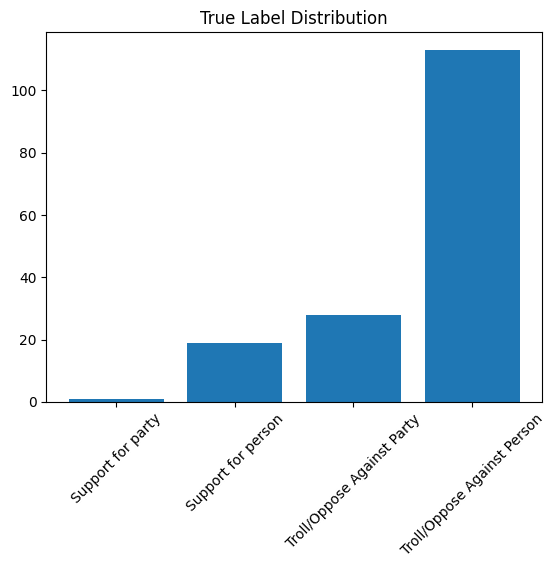

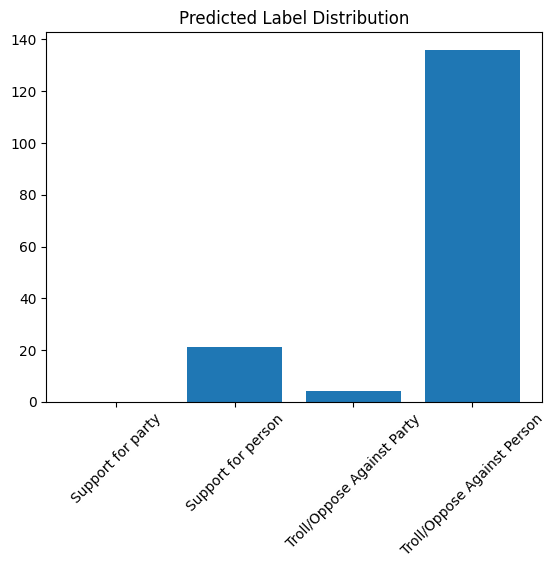

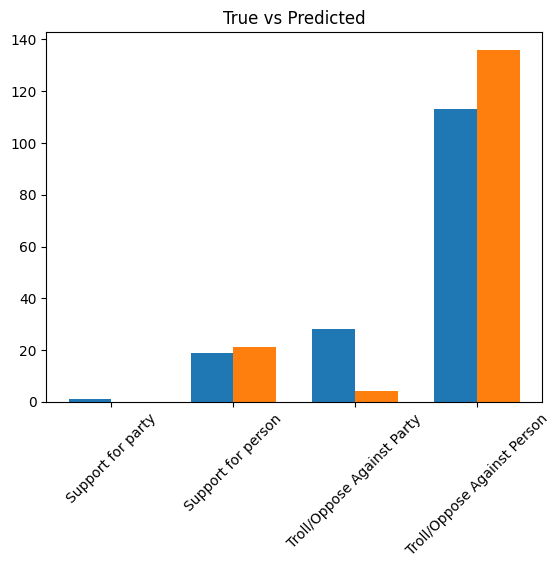

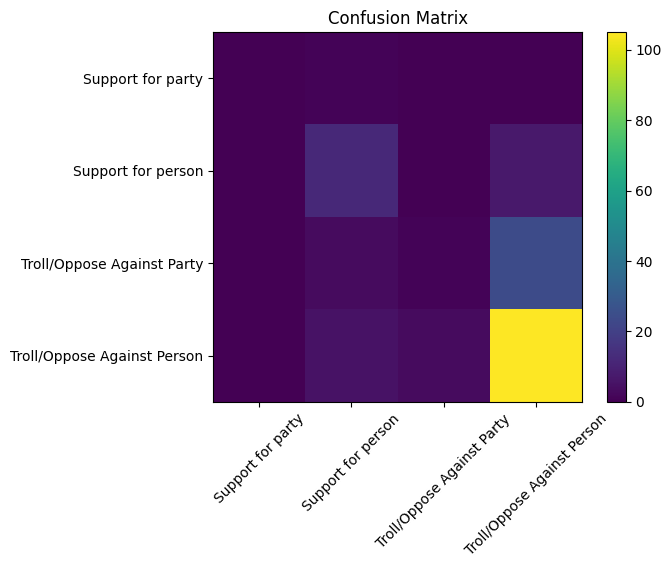

In [ ]:
y_true = np.array(all_true)
y_pred = np.array(all_preds)

true_counts = np.bincount(y_true, minlength=num_classes)
pred_counts = np.bincount(y_pred, minlength=num_classes)

# True Distribution
plt.figure()
plt.bar(range(num_classes), true_counts)
plt.xticks(range(num_classes), le.classes_, rotation=45)
plt.title("True Label Distribution")
plt.show()

# Predicted Distribution
plt.figure()
plt.bar(range(num_classes), pred_counts)
plt.xticks(range(num_classes), le.classes_, rotation=45)
plt.title("Predicted Label Distribution")
plt.show()

# Grouped
x = np.arange(num_classes)
width = 0.35

plt.figure()
plt.bar(x - width/2, true_counts, width)
plt.bar(x + width/2, pred_counts, width)
plt.xticks(x, le.classes_, rotation=45)
plt.title("True vs Predicted")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks(range(num_classes), le.classes_, rotation=45)
plt.yticks(range(num_classes), le.classes_)
plt.colorbar()
plt.show()
